In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
import open3d as o3d
from IPython.display import display, Math, Latex, Markdown, HTML

In [2]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q
    # draw initial correspondeces
    corresp_lines = []
    for i, j in correspondences:
        corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i]
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        draw_inc_corresp(P_inc, Q, corresp_values[i])
        return (P_line,)
    
    def draw_inc_corresp(points_from, points_to, correspondences):
        for corr_idx, (i, j) in enumerate(correspondences):
            x = [points_from[0, i], points_to[0, j]]
            y = [points_from[1, i], points_to[1, j]]
            corresp_lines[corr_idx].set_data(x, y)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())

In [15]:
pcd = o3d.io.read_point_cloud("pointcloud3.pcd")
pcd2 =  o3d.io.read_point_cloud("pointcloud4.pcd")
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])

PointCloud with 217088 points.
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [16]:
arr = np.asarray(pcd.points)
arr2 = np.asarray(pcd2.points)

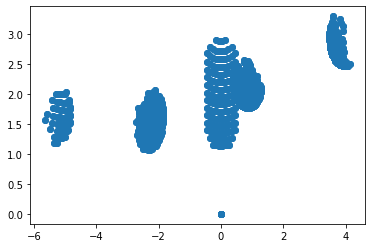

In [17]:
plt.scatter(arr[:,0],arr[:,1])

In [18]:
pts = arr[~np.all(arr == 0, axis=1)]

In [19]:
pts2 = arr2[~np.all(arr2 == 0, axis=1)]

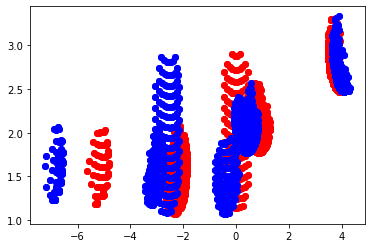

In [23]:
plt.scatter(pts[:,0],pts[:,1],color='red')
plt.scatter(pts2[:,0],pts2[:,1],color='blue')

In [50]:
def plot(pts,pts2):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    z_points = pts[2,:]
    x_points = pts[0,:]
    y_points = pts[1,:]
    ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

    z_points = pts2[2,:]
    x_points = pts2[0,:]
    y_points = pts2[1,:]
    ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

    plt.show()

In [27]:
Q = pts.T
P = pts2.T


(3, 3942)

In [33]:
def centered_data(data):
    center = np.expand_dims(np.array(np.mean(data,axis = 1)),axis=1)
    center_data = data - center
    return center,center_data

pd_center,pd =centered_data(P)
qd_center,qd = centered_data(Q)
print (pd.shape,qd.shape)

(3, 3942) (3, 3214)


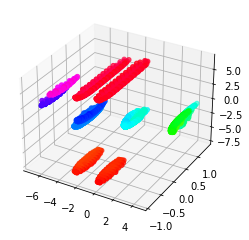

In [59]:
plot(pd,qd)

In [45]:
def find_corres(p,q):
    p_size = p.shape[1]
    q_size = q.shape[1]
    correspondence = []
    #print (p_size,q_size)
    for i in range(p_size):
        pp = p[:,i]
        mindist = sys.maxsize
        correspi = -1
        #print (i)
        for j in range(q_size):
            qq = q[:,j]
            dist = np.linalg.norm(pp-qq)
            if (dist<mindist):
                mindist = dist
                correspi = j
        correspondence.append((i,correspi))
    return correspondence

#corres = find_corres(pd,qd)

In [46]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((3, 3))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices


#cov,_ = compute_cross_covariance(pd,qd,corres)
#print (cov)

[[ 17009.63228174   2424.67419978  -2245.15873018]
 [  2322.06612672    608.09356295     96.39981814]
 [-13914.92998204   -453.10483463  25029.04954146]]


0


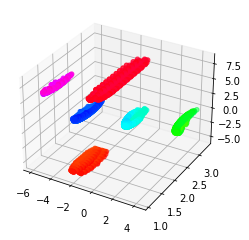

In [57]:
P_corrected = P
for epoch in range (1):
    print (epoch)
    
    #center data
    qd_center,qd = centered_data(Q)
    pd_center,pd = centered_data(P_corrected)
    
    #find correspondence
    corres = find_corres(pd,qd)

    #compute cross cov
    cov,_ = compute_cross_covariance(pd, qd, corres)
    
    #SVD
    U, S, V_T = np.linalg.svd(cov)
    R_found = U.dot(V_T)
    t_found = qd_center - R_found.dot(pd_center)
    
    #correct data and plot
    P_corrected = R_found.dot(P_corrected) + t_found
    #print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))
    
plot(P_corrected, Q)

0
1
2
3
4
5
6
7


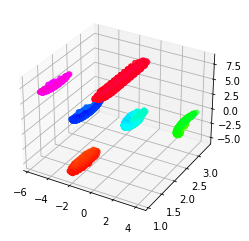

In [66]:
P_corrected = P
for epoch in range (8):
    print (epoch)
    
    #center data
    qd_center,qd = centered_data(Q)
    pd_center,pd = centered_data(P_corrected)
    
    #find correspondence
    corres = find_corres(pd,qd)

    #compute cross cov
    cov,_ = compute_cross_covariance(pd, qd, corres)
    
    #SVD
    U, S, V_T = np.linalg.svd(cov)
    R_found = U.dot(V_T)
    t_found = qd_center - R_found.dot(pd_center)
    
    #correct P
    P_corrected = R_found.dot(P_corrected) + t_found
    #print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))
    
#plot
plot(P_corrected, Q)

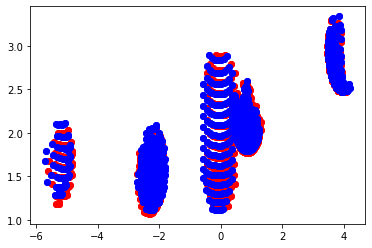

In [65]:
plt.scatter(Q[0,:],Q[1,:],color='red')
plt.scatter(P_corrected[0,:],P_corrected[1,:],color='blue')
#plt.scatter(P[0,:],P[1,:],color='green')

3